In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob # to list all files to a directory
import IPython
import IPython.display as ipd # to play the Audio Files

import librosa # main package for working with Audio Data
import librosa.display
import os
from time import time
from scipy.io import wavfile as wav

from tensorflow import keras
import tarfile
from shutil import copyfile

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


An instance of a track audio, genre 'blues':

In [ ]:
# Import file
sound_rate, sound_data = wav.read('/content/drive/MyDrive/Second year/DSIM_project/Data/genres_original/blues/blues.00001.wav')
# Play the signal
ipd.Audio(sound_data, rate= sound_rate)

In [ ]:
print("Shape of the audio array:", sound_data.shape)

Shape of the audio array: (661794,)


In [ ]:
print("Sampling rate per second:", sound_rate) 

Sampling rate per second: 22050


In [ ]:
print('Length of the song (sec):', sound_data.shape[0]/sound_rate)

Length of the song (sec): 30.013333333333332


Temporal representation

In [ ]:
sound_time = np.arange(sound_data.shape[0])*1.0/sound_rate

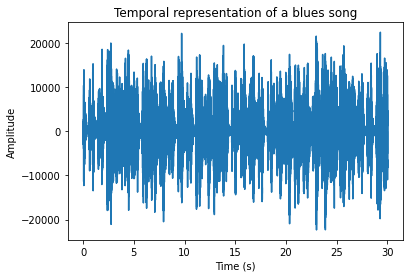

In [ ]:
# Visualizing a signal (temporal representation)
plt.plot(sound_time, sound_data);
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Temporal representation of a blues song')
plt.show()

Fast Fourier Transform (Frequency representation)

In [ ]:
# Conversion into the frequency domain for real input data
sound_rfft = rfft(sound_data)
sound_rfreqs = rfftfreq(len(sound_data), 1.0/sound_rate)

In [ ]:
# Shape of the temporal representation
sound_data.shape

(661794,)

In [ ]:
# Shape of the frequency representation
sound_rfft.shape

(330898,)

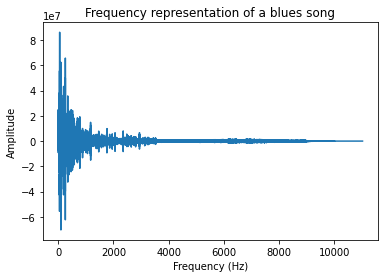

In [ ]:
# Visualizing the frequency signal
plt.plot(sound_rfreqs, np.real(sound_rfft));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation of a blues song')
plt.show()

#### **Spectrogram**

In [ ]:
S = librosa.feature.melspectrogram(y=sound_data*1.0, sr= sound_rate) 

In [ ]:
S.shape

(128, 1293)

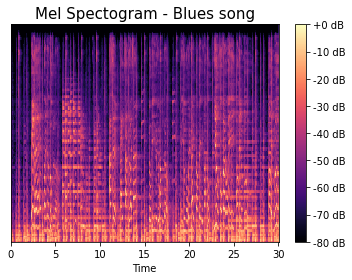

In [ ]:
# S = librosa.feature.melspectrogram(y=s_data*1.0, sr= sound_rate) 
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time')
plt.title('Mel Spectogram - Blues song', fontsize=15)
plt.colorbar(format='%+2.0f dB');

#### Data cleaning 
JOIN all the files in one single folder

In [ ]:
import os
import shutil

# specify the path to the parent folder containing the 10 folders
parent_folder_path = '/content/drive/MyDrive/Second year/DSIM_project/Data/genres_original'

# specify the path to the destination folder where you want to store the combined files
destination_folder_path = '/content/drive/MyDrive/Second year/DSIM_project/gtzan' #new folder created 

# loop through each subfolder in the parent folder
for subfolder in os.listdir(parent_folder_path):
    subfolder_path = os.path.join(parent_folder_path, subfolder)
    # loop through each file in the subfolder
    for file in os.listdir(subfolder_path):
        # construct the path to the file
        file_path = os.path.join(subfolder_path, file)
        # copy the file to the destination folder
        shutil.copy2(file_path, destination_folder_path)


##### **Unsupported format data**
File format b'\xcb\x15\x1e\x16' is not understood. Only 'RIFF' and 'RIFX' is supported.
Therefore, we check if a file is in the RIFF or RIFX format by checking the first four bytes of the file. We will remove this data from the dataset.

As we can see, the following file is not supported. 

In [ ]:
import os

def check_format(folder_path: str): #checking for unsupported data format
    not_riff_rifx_files = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'rb') as f:
                header = f.read(4)
                if header != b'RIFF' and header != b'RIFX':
                    not_riff_rifx_files.append(file_name)
    return not_riff_rifx_files 

In [ ]:
check_format('/content/drive/MyDrive/Second year/DSIM_project/gtzan')

['jazz.00054.wav']

#### Data split into train and test (90% , 10%)
called gtzan_train and gtzan_test.
gtzan_train will be used for SVM 

In [ ]:
import os
import random
import shutil
project_path = '/content/drive/MyDrive/Second year/DSIM_project'
root_dir = '/content/drive/MyDrive/Second year/DSIM_project/Data/genres_original'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

train_dir = os.path.join(project_path, 'gtzan_train') #nuova cartella train
test_dir = os.path.join(project_path, 'gtzan_test') #nuova cartella test

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

for genre in genres:
    genre_dir = os.path.join(root_dir, genre) #per ogni genere, prendi path
    files = os.listdir(genre_dir) #lista delle canzoni in quel genere 
    num_files = len(files) #conta
    num_train = int(num_files * 0.9) #prendi 90%
    num_test = num_files - num_train #10% per il test
    
    random.shuffle(files) #divisione randomica dei file tra train e test
    train_files = files[:num_train]
    test_files = files[num_train:]
    
    for file in train_files:
        src_path = os.path.join(genre_dir, file)
        dst_path = os.path.join(train_dir, file)
        shutil.copy(src_path, dst_path)
    
    for file in test_files:
        src_path = os.path.join(genre_dir, file)
        dst_path = os.path.join(test_dir, file)
        shutil.copy(src_path, dst_path)


The file jazz 00054 will be deleted from the dataset. 


In [ ]:
 os.remove('/content/drive/MyDrive/Second year/DSIM_project/gtzan/jazz.00054.wav')

#### **Data loader**

Considering the gtzan_train set, composed of 90% of the starting dataset, it is furthermore divided into train and validation, using a split of 80/20

In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('/content/drive/MyDrive/Second year/DSIM_project/gtzan_train_val/')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('/content/drive/MyDrive/Second year/DSIM_project/gtzan_train_val/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('.')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

#### Feature extractor: Spectral Features 
capture the spectral characteristics of a sound. 
1. Mel Spectrogram
2. MFCC

###### **Mel Spectrogram**

In [ ]:
S = librosa.feature.melspectrogram(y=sound_data*1.0, sr = sound_rate) 

In [ ]:
len(sound_data)

661794

In [ ]:
S.shape

(128, 1293)

In [ ]:
def mel(signal, sound_rate = 22050, tsize=1000):
  S = librosa.feature.melspectrogram(y=signal*1.0, sr = sound_rate)  #S = array
  output = (S[:,0:min(tsize, S.shape[1])]) #consider only the minimum number of columns between tsize and the number of columns of the spectrogram 
  output = np.concatenate((output, np.zeros((S.shape[0],(tsize-output.shape[1])))), axis=1) #add zeros matrix when the columns of the spectrogram 
  #are less than tsize = 10. Column concatenation
  output = output.flatten(order='F') #unroll the matrix, following column order. 
  return np.array(output)


In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=mel, normalize = True)
print('Numer of training examples: {}'.format(len(X_train)))
print('Dimensionality of the training features: {}'.format(X_train[0].shape))

Numer of training examples: 719
Dimensionality of the training features: (128000,)


In [ ]:
# Support Vector Machine initialization
clf = SVC(kernel='rbf', class_weight='balanced')

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Mel Spectrogram - training completed in %0.3fs' % (time() - t0))

Mel Spectrogram - training completed in 120.017s


In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

       blues       0.60      0.14      0.22        22
   classical       0.21      0.92      0.35        13
     country       0.38      0.14      0.21        21
       disco       0.00      0.00      0.00        10
      hiphop       0.50      0.05      0.10        19
        jazz       0.31      0.17      0.22        23
       metal       0.77      0.62      0.69        16
         pop       0.27      0.73      0.40        22
      reggae       0.25      0.21      0.23        14
        rock       0.57      0.20      0.30        20

    accuracy                           0.31       180
   macro avg       0.39      0.32      0.27       180
weighted avg       0.41      0.31      0.28       180



Mel spectrogram - Confusion matrix:


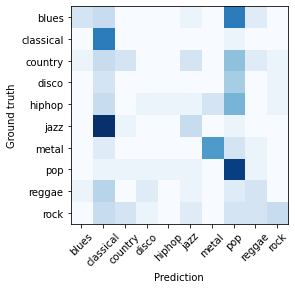

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print('Mel spectrogram - Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
class_names = clf.classes_

plt.imshow(cm, cmap=plt.cm.Blues)
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)


plt.show()


Using the Mel Spectrogram as a feature extract, lead to an accuracy of 31%, using a SVM.

In [ ]:
parent_folder_path = '/content/drive/MyDrive/Second year/DSIM_project/Data/genres_original/'

In [ ]:
def display_melspectrogram(parent_folder_path):
    genres = os.listdir(parent_folder_path)
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),  sharex=False, sharey=True, constrained_layout=True) 

    for i, subfolder in enumerate(genres):
        subfolder_path = os.path.join(parent_folder_path, subfolder)
        files = os.listdir(subfolder_path)
        file_path = os.path.join(subfolder_path, files[0])
        y, sr = librosa.load(file_path, sr=None)
        melspectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y))
        img = librosa.display.specshow(melspectrogram, sr=sr, x_axis='time', y_axis='mel', ax=axs[i // 5][i % 5], cmap='inferno')
        axs[i // 5][i % 5].set_title(subfolder.capitalize())
  
    fig.colorbar(img, ax=[axs[1]], format='%+2.0f dB')
    fig.colorbar(img, ax=[axs[0]], format='%+2.0f dB')

    plt.savefig("/content/drive/MyDrive/Second year/DSIM_project/mel_genres.png")


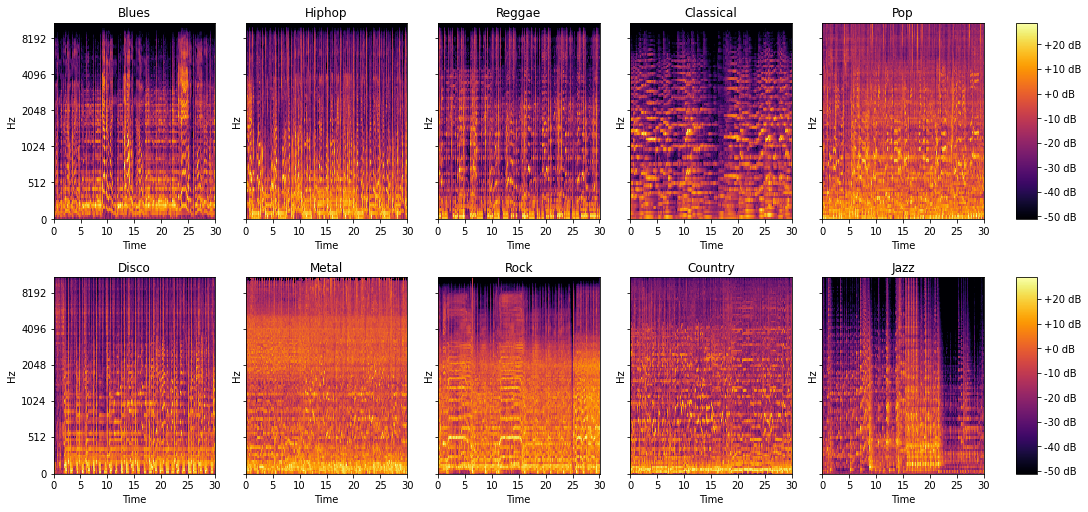

In [ ]:
#Mel Spectrogram, a song for for each genre
display_melspectrogram(parent_folder_path)

###### **MFCC**

In [ ]:
mfccs = librosa.feature.mfcc(sound_data*1.0, sr=sound_rate)

In [ ]:
mfccs.shape #20 features 

(20, 1293)

In [ ]:
type(mfccs)

numpy.ndarray

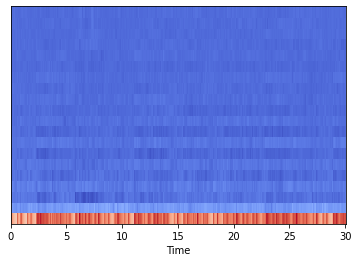

In [ ]:
librosa.display.specshow(mfccs, sr=sound_rate, x_axis='time')

In [ ]:
def mel_fcc(signal, sound_rate = 22050, tsize=1000):
  mfccs = librosa.feature.mfcc(signal*1.0, sr=sound_rate)
  output = (mfccs[:,0:min(tsize, mfccs.shape[1])]) #consider only the minimum number of columns between tsize and the number of columns of the spectrogram 
  output = np.concatenate((output, np.zeros((mfccs.shape[0],(tsize-output.shape[1])))), axis=1) #add zeros matrix when the columns of the spectrogram 
  #are less than tsize = 10. Column concatenation
  output = output.flatten(order='F') #unroll the matrix, following column order. 
  return np.array(output)

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=mel_fcc, normalize = True)
print('Numer of training examples: {}'.format(len(X_train)))
print('Dimensionality of the training features: {}'.format(X_train[0].shape))

Numer of training examples: 719
Dimensionality of the training features: (20000,)


In [ ]:
# Support Vector Machine initialization
clf = SVC(kernel='rbf', class_weight='balanced')

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Mel Frequency Cepstral Coefficients (MFCCs) - training completed in %0.3fs' % (time() - t0))

Mel Frequency Cepstral Coefficients (MFCCs) - training completed in 11.221s


In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print('MFCC Classification report :')
print(classification_report(y_test, y_pred))

MFCC Classification report :
              precision    recall  f1-score   support

       blues       0.50      0.27      0.35        22
   classical       0.75      0.92      0.83        13
     country       0.53      0.48      0.50        21
       disco       0.26      0.50      0.34        10
      hiphop       0.70      0.37      0.48        19
        jazz       0.64      0.61      0.62        23
       metal       0.65      0.94      0.77        16
         pop       0.53      0.77      0.63        22
      reggae       0.33      0.36      0.34        14
        rock       0.25      0.15      0.19        20

    accuracy                           0.52       180
   macro avg       0.51      0.54      0.51       180
weighted avg       0.52      0.52      0.50       180



MFCC - Confusion matrix:


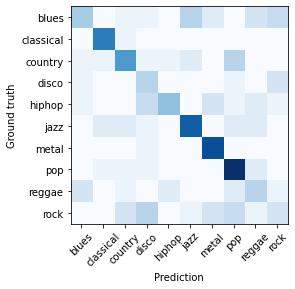

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print('MFCC - Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
class_names = clf.classes_

plt.imshow(cm, cmap=plt.cm.Blues)
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)


plt.show()

Using MFCC as a feature extractor, improved accuracy to 52%.

In the following, the MFCC visualizations are displayed for a random song from each genre.

In [ ]:
def display_mfcc(parent_folder_path):
    genres = os.listdir(parent_folder_path)
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),  sharex=False, sharey=True, constrained_layout=True)
  
    for i, subfolder in enumerate(genres):
        subfolder_path = os.path.join(parent_folder_path, subfolder)
        files = os.listdir(subfolder_path)
        file_path = os.path.join(subfolder_path, files[0])
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        img = librosa.display.specshow(mfccs, x_axis='time', ax=axs[i // 5][i % 5])
        axs[i // 5][i % 5].set_title(subfolder.capitalize())
    
    fig.colorbar(img, ax=[axs[1]])
    fig.colorbar(img, ax=[axs[0]])
    
    plt.savefig("/content/drive/MyDrive/Second year/DSIM_project/mfcc_genres.png")
    plt.show()

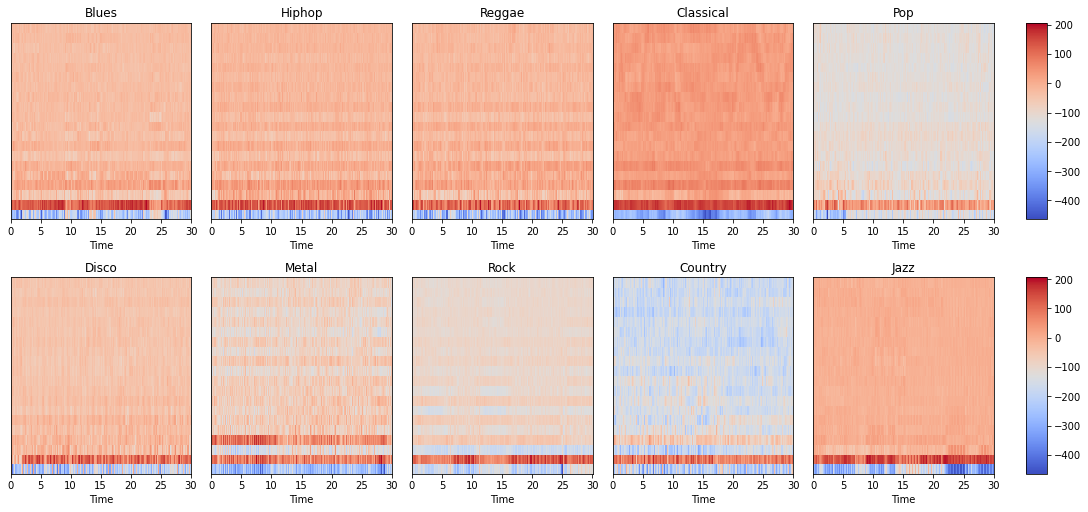

In [ ]:
display_mfcc(parent_folder_path)

#### **Chroma feature** (chromagram)
which can capture the underlying harmonic structure of a sound and distinguish between different musical instruments and genres

Chroma feature refers to a representation of an audio signal that captures harmonic and melodic characteristics, primarily the 12 pitch classes. It transforms the audio signal into a 12-dimensional feature space, where each dimension represents a semitone in the Western music scale.

In [ ]:
def chroma_feature(signal, sound_rate = 22050, tsize=1000):
  ch = librosa.feature.chroma_stft(signal*1.0, sr=sound_rate) #Compute a chromagram from a waveform
  output = (ch[:,0:min(tsize, ch.shape[1])]) 
  output = np.concatenate((output, np.zeros((ch.shape[0],(tsize-output.shape[1])))), axis=1) 
  output = output.flatten(order='F') 
  return np.array(output)

In [ ]:
len(chroma_feature(sound_data)) 

12000

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=chroma_feature, normalize = True)
print('Numer of training examples: {}'.format(len(X_train)))
print('Dimensionality of the training features: {}'.format(X_train[0].shape))

Numer of training examples: 719
Dimensionality of the training features: (12000,)


In [ ]:
# Support Vector Machine initialization
clf = SVC(kernel='rbf', class_weight='balanced')

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Chroma feature - training completed in %0.3fs' % (time() - t0))

Chroma feature - training completed in 6.416s


In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print('Chroma: Classification report :')
print(classification_report(y_test, y_pred))

Chroma: Classification report :
              precision    recall  f1-score   support

       blues       0.24      0.23      0.23        22
   classical       0.41      0.85      0.55        13
     country       0.23      0.14      0.18        21
       disco       0.10      0.20      0.13        10
      hiphop       0.73      0.42      0.53        19
        jazz       0.54      0.30      0.39        23
       metal       0.54      0.88      0.67        16
         pop       0.38      0.23      0.29        22
      reggae       0.55      0.43      0.48        14
        rock       0.28      0.35      0.31        20

    accuracy                           0.38       180
   macro avg       0.40      0.40      0.38       180
weighted avg       0.40      0.38      0.37       180



Chroma - Confusion matrix:


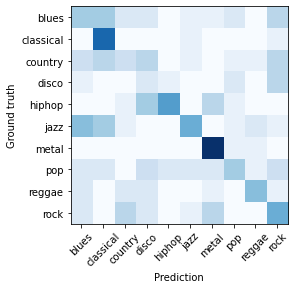

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print('Chroma - Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
class_names = clf.classes_

plt.imshow(cm, cmap=plt.cm.Blues)
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# for i in range(len(class_names)):
#     for j in range(len(class_names)):
#         plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

plt.show()


Using a **chroma feature**, the SVM reached an accuracy of 38% .

In [ ]:
def display_chroma(parent_folder_path):
    genres = os.listdir(parent_folder_path)
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),  sharex=False, sharey=True, constrained_layout=True)
  
    for i, subfolder in enumerate(genres):
        subfolder_path = os.path.join(parent_folder_path, subfolder)
        files = os.listdir(subfolder_path)
        file_path = os.path.join(subfolder_path, files[0])
        y, sr = librosa.load(file_path, sr=None)
        ch = librosa.feature.chroma_stft(y*1.0, sr=sr) 
        img = librosa.display.specshow(ch, y_axis='chroma', x_axis='time', ax=axs[i // 5][i % 5])
        axs[i // 5][i % 5].set_title(subfolder.capitalize())
    
    fig.colorbar(img, ax=[axs[1]])
    fig.colorbar(img, ax=[axs[0]])
    
    plt.savefig("/content/drive/MyDrive/Second year/DSIM_project/chroma_genres.png")
    plt.show()

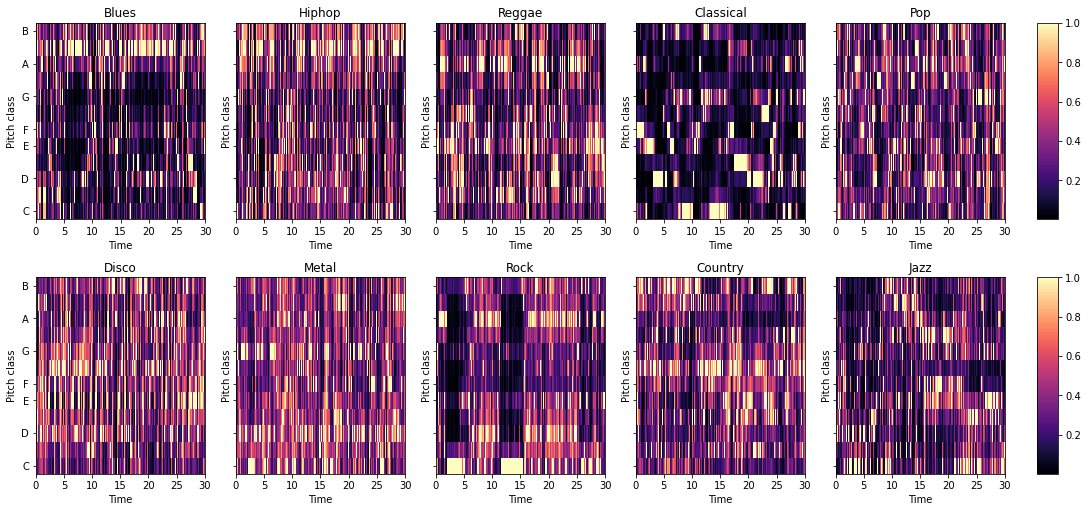

In [ ]:
display_chroma(parent_folder_path)

#### **Using MFCC features as input for CNN**

##### Creation of mfcc spectrograms (for each song of every genre in the dataset gtzan_train) and storing the images in **mfcc_images_train** and **mfcc_images_val** folder, divided by subfolders representing the different genres.

First, we need to split the dataset gtzan_train_val into two separate folders, gtzan_train and gtzan_val

In [ ]:
project_path = '/content/drive/MyDrive/Second year/DSIM_project'

In [ ]:
train_folder = '/content/drive/MyDrive/Second year/DSIM_project/gtzan_train'

In [ ]:
validation_folder = '/content/drive/MyDrive/Second year/DSIM_project/gtzan_validation'

In [ ]:
gtzan_train_val = os.path.join(project_path,'gtzan_train_val') #all files for train and validation

In [ ]:
import os
import random
import shutil

# Root directory of the dataset
root_dir = gtzan_train_val

# List all the .wav files in the root directory
files = [f for f in os.listdir(root_dir) if f.endswith(".wav")]

# Split ratio for train and validation sets
train_ratio = 0.8

# Create the destination directories
train_dest_dir = train_folder
val_dest_dir = validation_folder
os.makedirs(train_dest_dir, exist_ok=True)
os.makedirs(val_dest_dir, exist_ok=True)

# Dictionary to store the files for each label
labels = {}

# Loop through each file
for file in files:
    # Extract the label and name from the file path
    label, name = file.split(".")[:2]

    # Add the file to the list of files for the label
    if label not in labels:
        labels[label] = []
    labels[label].append(file)

# Loop through each label
for label, label_files in labels.items():
    # Shuffle the list of files for the label
    random.shuffle(label_files)

    # Calculate the split index for train and validation sets
    split_index = int(len(label_files) * train_ratio)

    # Split the files into train and validation sets
    train_files = label_files[:split_index]
    val_files = label_files[split_index:]

    # Copy the train files to the destination directory
    for file in train_files:
        src = os.path.join(root_dir, file)
        dst = os.path.join(train_dest_dir, file)
        shutil.copy2(src, dst)

    # Copy the validation files to the destination directory
    for file in val_files:
        src = os.path.join(root_dir, file)
        dst = os.path.join(val_dest_dir, file)
        shutil.copy2(src, dst)


In [ ]:
# mfcc_images = os.path.join(project_path, 'mfcc_images') #mfcc spectrogram for the entire gtzaz_train dataset (90% of whole dataset gtzan)

In [ ]:
import librosa
import matplotlib.pyplot as plt
import os

def create_mfcc_spectrogram(gtzan, mfcc_images):
    if not os.path.exists(mfcc_images):
        os.makedirs(mfcc_images) 

    for file in os.listdir(gtzan):
        file_path = os.path.join(gtzan, file)
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y*1.0, sr=sr)
        label = file.split('.')[0]
        label_dir = os.path.join(mfcc_images, label)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1,
                        wspace=None, hspace=None)

        if not os.path.exists(label_dir):
            os.makedirs(label_dir)

        save_path = os.path.join(label_dir, file.split('.')[1] + ".png")
        plt.savefig(save_path, frameon=False, dpi=100, bbox_inches='tight', pad_inches=0)
        plt.close()


In [ ]:
mfcc_train = '/content/drive/MyDrive/Second year/DSIM_project/mfcc_train'

In [ ]:
create_mfcc_spectrogram(train_folder, mfcc_train)  #create mfcc for train set

In [ ]:
mfcc_validation = '/content/drive/MyDrive/Second year/DSIM_project/mfcc_validation'

In [ ]:
create_mfcc_spectrogram(validation_folder, mfcc_validation)  #create mfcc for validation set

##### The dataset mfcc_images jus created, will be split into **train** (80%), **validation** (20%), in order to feed the CNN . 

In [ ]:
os.listdir(mfcc_images)

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [ ]:
train = '/content/drive/MyDrive/Second year/DSIM_project/mfcc_train'

In [ ]:
validation = '/content/drive/MyDrive/Second year/DSIM_project/mfcc_validation'

In [ ]:
import os
import random
import shutil

source_folder = mfcc_images
train_folder = train
validation_folder = validation
train_percent = 0.8

# Create train and test folders if they don't exist
if not os.path.exists(train_folder):
  os.makedirs(train_folder)
if not os.path.exists(validation_folder):
  os.makedirs(validation_folder)

# Iterate over the genres subfolders
for genre in os.listdir(source_folder):
    genre_folder = os.path.join(source_folder, genre)
    if os.path.isdir(genre_folder):
        # Create a train and test subfolder for each genre
        genre_train = os.path.join(train_folder, genre) #creazione path
        genre_validation = os.path.join(validation_folder, genre)
        if not os.path.exists(genre_train): 
            os.makedirs(genre_train) #creazione in cartella train delle sottocartelle dei generi
        if not os.path.exists(genre_validation): 
            os.makedirs(genre_validation)

        images = os.listdir(genre_folder)
       # Shuffle the images
        random.shuffle(images)
        num_train = int(len(images) * train_percent)
        # Copy the first `num_train` images to the train subfolder
        for image in images[:num_train]:
            shutil.copy2(os.path.join(genre_folder, image), genre_train)
        # copy the next `num_validation` images to the validation subfolder
        for image in images[num_train:]:
            shutil.copy2(os.path.join(genre_folder, image), genre_validation)

